# Equity Options Portfolio Optimization:
**Authors:** William Lester, Luke Rutherford, Dylan Kynoch, Henry Daniel \
**Start Date:** 4/17/2024 \
**Last Updated:** 4/19/2024

In [8]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt
import data_functions as dat_func, visualizations as vis
import yfinance as yf
from datetime import datetime
import QuantLib as ql
from scipy.optimize import minimize
import warnings
import pickle

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)

In [34]:
start_date,end_date="2023-04-19",'2024-04-19'
start_date,end_date=pd.to_datetime(start_date),pd.to_datetime(end_date)
trade_dates=dat_func.get_trading_days(start_date,end_date)

tickers = [
    "XLC", "GOOG", "TMUS", "EA", "CMCSA", # Comms
    "MCD", "BKNG", "NKE", "SBUX", # Cons. Disc
    "XLP", "TGT", "MO", # Cons. Staples
    "XLE", "XOM", "CVX", "COP", "EOG", "PXD", "WMB", # Energy
    "XLF", "JPM", "V", "MA", "SPGI", "PGR", # Financials
    "JNJ", "MRK", "TMO", "PFE", "AMGN", # Health
    "CAT", "GE", "UNP", "RTX", "HON", "ETN", "UPS", "DE", "ADP", # Industrials
    "LIN", "SHW", "ECL", "APD", "NUE", "CTVA", "MLM", # Materials
    "XLRE", "AMT", "EQIX", "WELL", "SPG", "O", "PSA", "CCI", "CSGP", # Real Estate
    "XLK", "AVGO", "ORCL", # Tech
    "XLU", "SO", "AEP", "D", "EXC", # Utilities
]

# tickers = ['XLC','MCD','XLP','XLE','JPM','JNJ','CAT','LIN','XLRE','XLK','XLU']
#tickers=['FI','STLD','GOOG','BKNG','XOM']
ex_stock='JPM'

[*********************100%%**********************]  63 of 63 completed


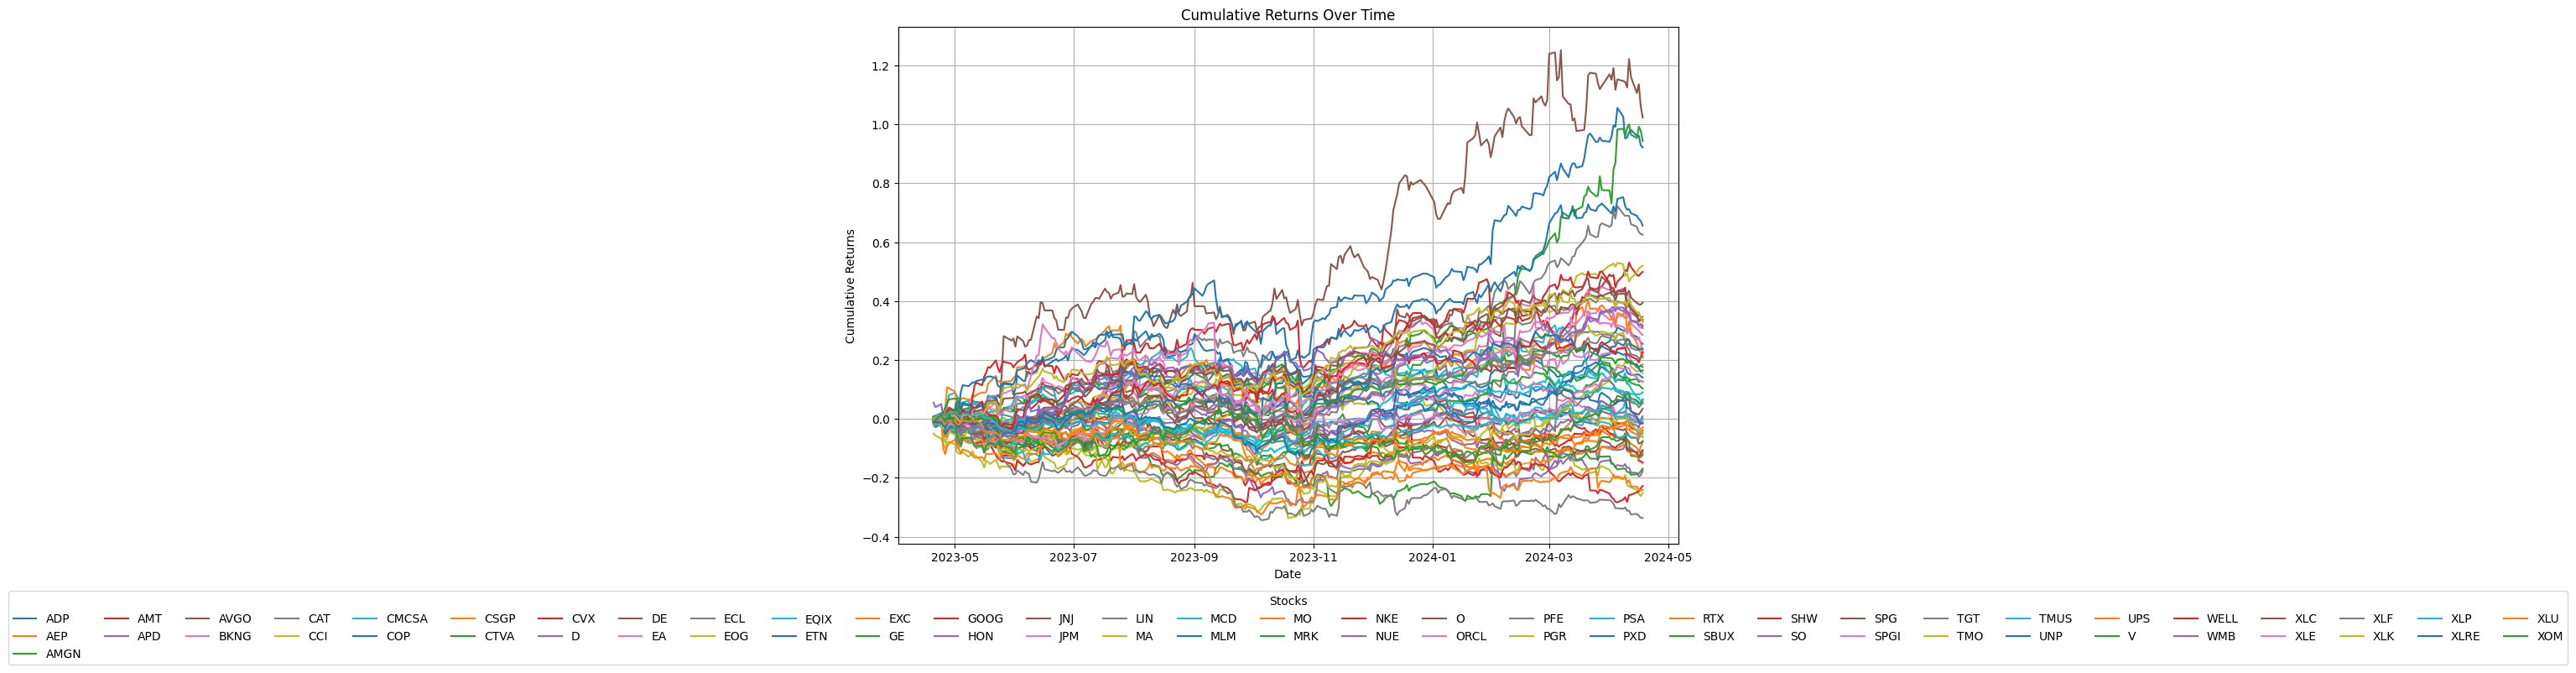

In [35]:
stock_df=dat_func.get_price_df(tickers,start_date,end_date)
returns_df=dat_func.get_log_returns(stock_df)
vis.plot_cumulative_returns(returns_df)

In [11]:
fred,poly=dat_func.connect_apis()
risk_free_rate=fred.get_series('GS10').iloc[-1]/100

In [12]:
init_weights,init_ret,init_std=dat_func.get_init_port(returns_df,risk_free_rate,leverage_limit=0.2)
init_weights=init_weights.round(3)
print('Initial Port Returns:',init_ret)
print('Initial Port Volatility:',init_std)
print('Initial Port Sharpe:',(init_ret-risk_free_rate)/init_std)
print('Optimal Weights:',dict(zip(returns_df.columns,init_weights)))

Initial Port Returns: 0.21853743400906225
Initial Port Volatility: 0.06958116681878601
Initial Port Sharpe: 2.5357067447369457
Optimal Weights: {'CAT': 0.147, 'JNJ': -0.083, 'JPM': 0.161, 'LIN': 0.105, 'MCD': -0.063, 'XLC': 0.2, 'XLE': -0.025, 'XLK': 0.01, 'XLP': -0.004, 'XLRE': -0.2, 'XLU': -0.0}


In [13]:
with open('Data\\init_sim_port_weights.pkl', 'wb') as handle:
    pickle.dump(init_weights, handle, protocol=pickle.HIGHEST_PROTOCOL)

## Initial Portfolio Simulation:
### Geometric Brownian Motion: 

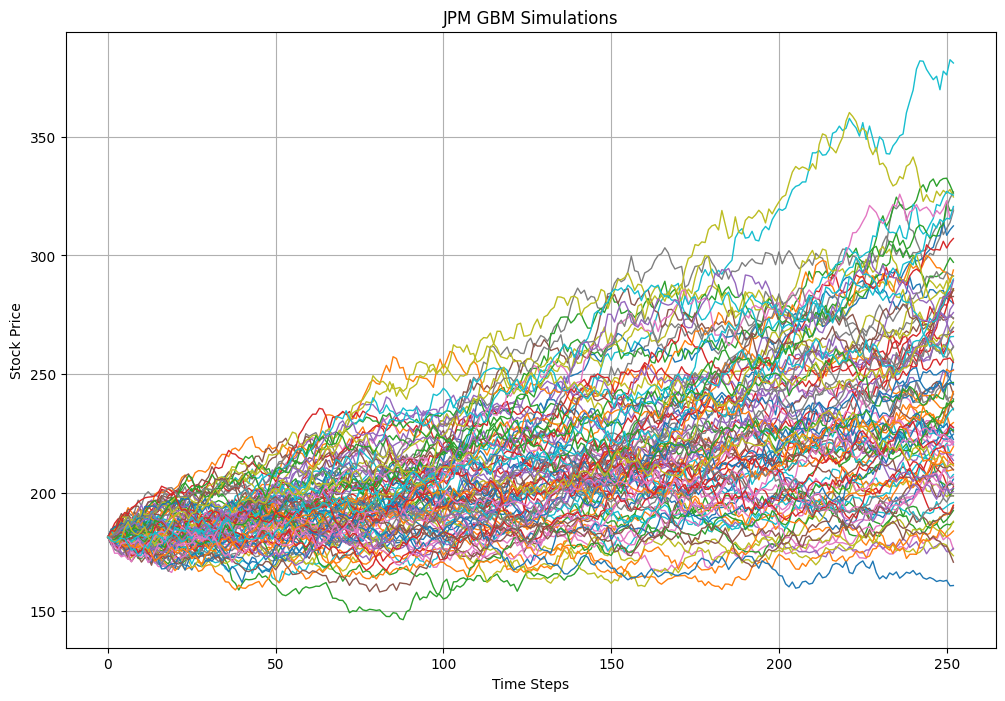

In [14]:
gpc_gbm=dat_func.simulate_gbm(stock_df[ex_stock][-1],returns_df.mean()[ex_stock]*252,returns_df.std()[ex_stock]*np.sqrt(252),1,N=100)
vis.plot_paths(gpc_gbm,f'{ex_stock} GBM',False)

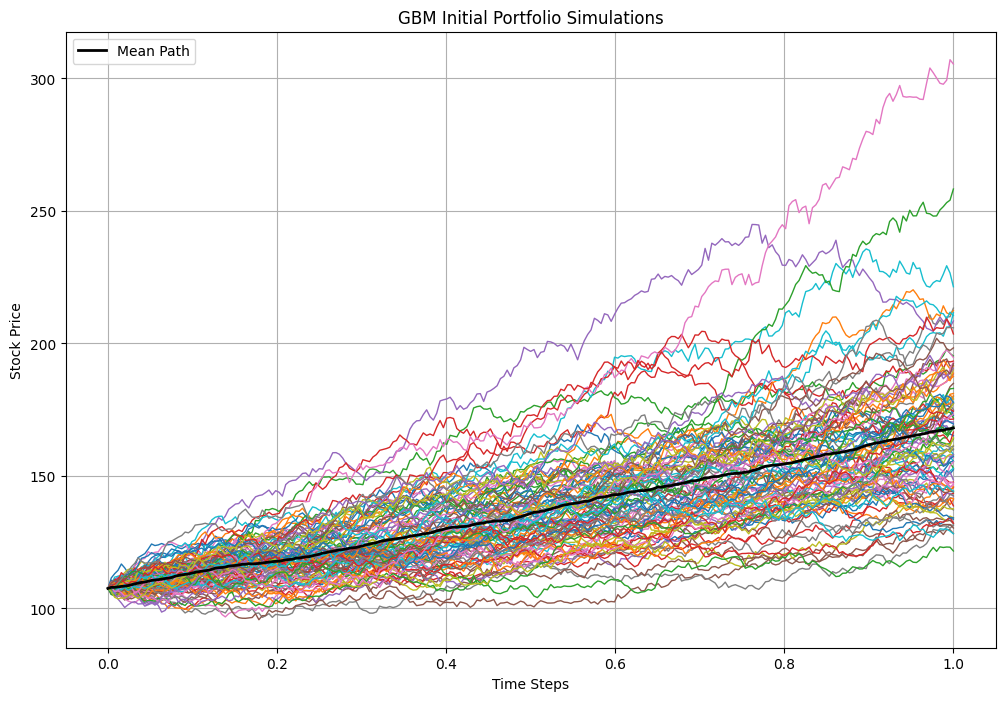

In [15]:
gbm_init_port=dat_func.simulate_gbm_portfolio(returns_df,stock_df,init_weights)
vis.plot_paths(gbm_init_port.iloc[:100],'GBM Initial Portfolio',True)

In [16]:
gbm_ret=(gbm_init_port.mean(axis=0).iloc[-1]-gbm_init_port.mean(axis=0).iloc[0])/gbm_init_port.mean(axis=0).iloc[0]
print(f'GBM Initial Portfolio Return: {round(gbm_ret*100,2)}%')

GBM Initial Portfolio Return: 57.96%


### Merton Jump Diffusion: 

In [17]:
# Estimate the number of jumps, mean jump, and vol of jumps
gpc_lambda_,gpc_m,gpc_v=dat_func.estimate_merton_params(returns_df[ex_stock])

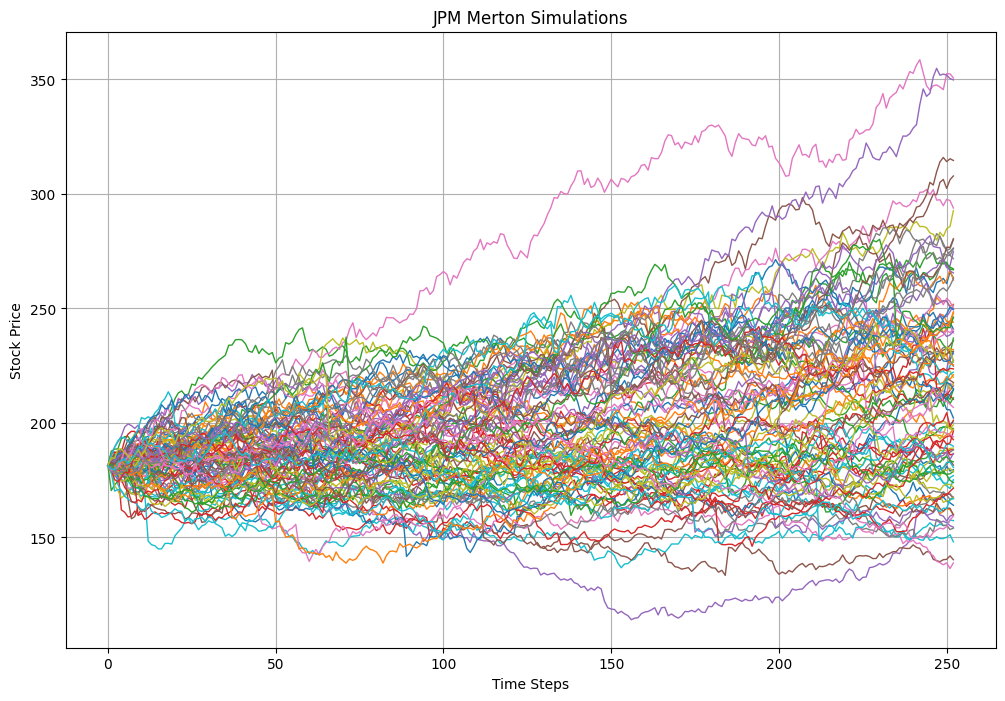

In [18]:
gpc_merton=dat_func.simulate_merton(stock_df[ex_stock][-1],returns_df.mean()[ex_stock]*252,returns_df.std()[ex_stock]*np.sqrt(252),1,gpc_lambda_,gpc_m,gpc_v,1/252,100)
vis.plot_paths(gpc_merton,f'{ex_stock} Merton')

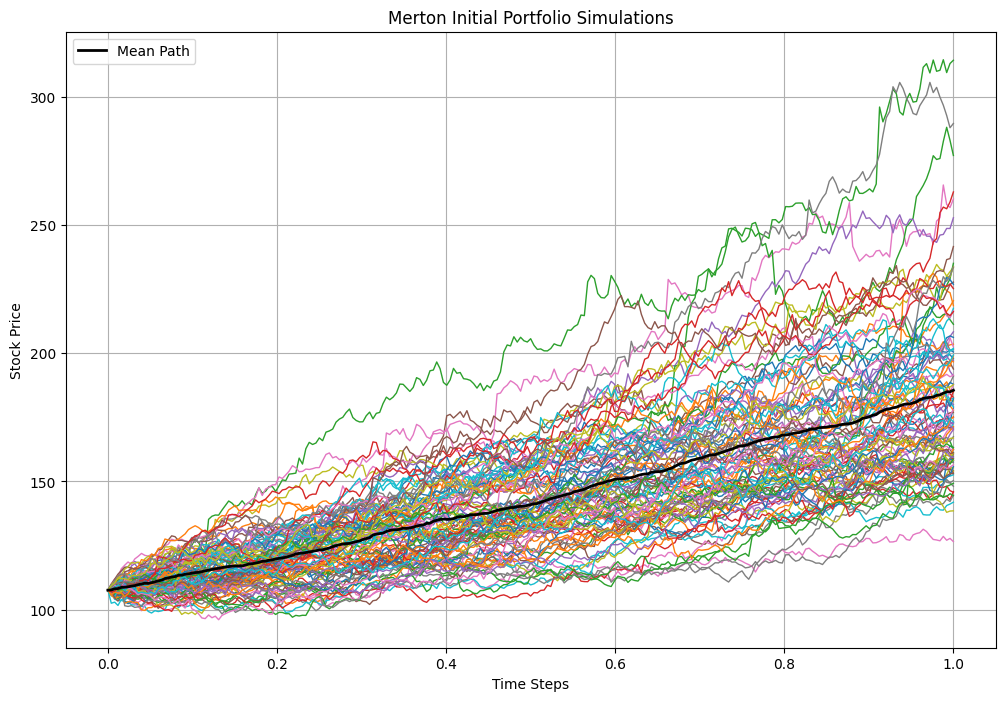

In [19]:
merton_init_port=dat_func.simulate_merton_portfolio(returns_df,stock_df,init_weights)
vis.plot_paths(merton_init_port.iloc[:100],'Merton Initial Portfolio',True)

In [20]:
merton_ret=(merton_init_port.mean(axis=0).iloc[-1]-merton_init_port.mean(axis=0).iloc[0])/merton_init_port.mean(axis=0).iloc[0]
print(f'Merton Initial Portfolio Return: {round(merton_ret*100,2)}%')

Merton Initial Portfolio Return: 68.43%


### Constant Elasticity of Variance (CEV): 

Estimated JPM CEV Parameters: mu=0.0011668442828789082, std=0.004276013209106984, gamma=1.1802476250389915


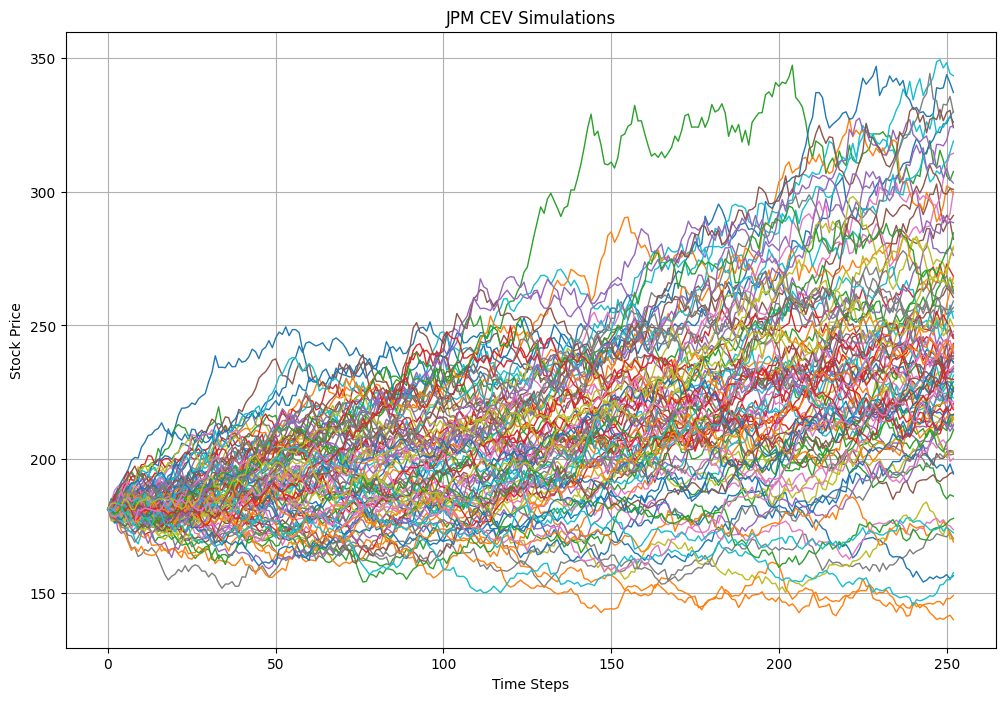

In [21]:
cev_ex_params=dat_func.estimate_cev_params(stock_series=stock_df[ex_stock])
simulated_prices = dat_func.simulate_cev(stock_df[ex_stock][-1],cev_ex_params[0]*252,cev_ex_params[1]*np.sqrt(252), gamma=cev_ex_params[2], T=1)
vis.plot_paths(simulated_prices[:100],f'{ex_stock} CEV')

Estimated CAT CEV Parameters: mu=0.0019522483298324313, std=2.474167083987082, gamma=0.10262909908557175
Estimated JNJ CEV Parameters: mu=-0.00021736712860384897, std=6.059127161340667e-05, gamma=1.9979837836916339
Estimated JPM CEV Parameters: mu=0.0011668442828789082, std=0.004276013209106984, gamma=1.1802476250389915
Estimated LIN CEV Parameters: mu=0.0008649337728493311, std=0.2018058875051313, gamma=0.5021241384711236
Estimated MCD CEV Parameters: mu=-0.00019891143730459569, std=0.17518619559172285, gamma=0.4730267010742547
Estimated XLC CEV Parameters: mu=0.0012330686837488214, std=0.7290676305378481, gamma=0.0
Estimated XLE CEV Parameters: mu=0.000448423187477978, std=1.0066826972132676, gamma=0.0
Estimated XLK CEV Parameters: mu=0.0010732132435837525, std=0.1725011982299986, gamma=0.472409482857601
Estimated XLP CEV Parameters: mu=-1.9855543970422314e-05, std=0.4688248463733853, gamma=0.0
Estimated XLRE CEV Parameters: mu=-0.00012692172140680409, std=0.4225993039393077, gamma=0

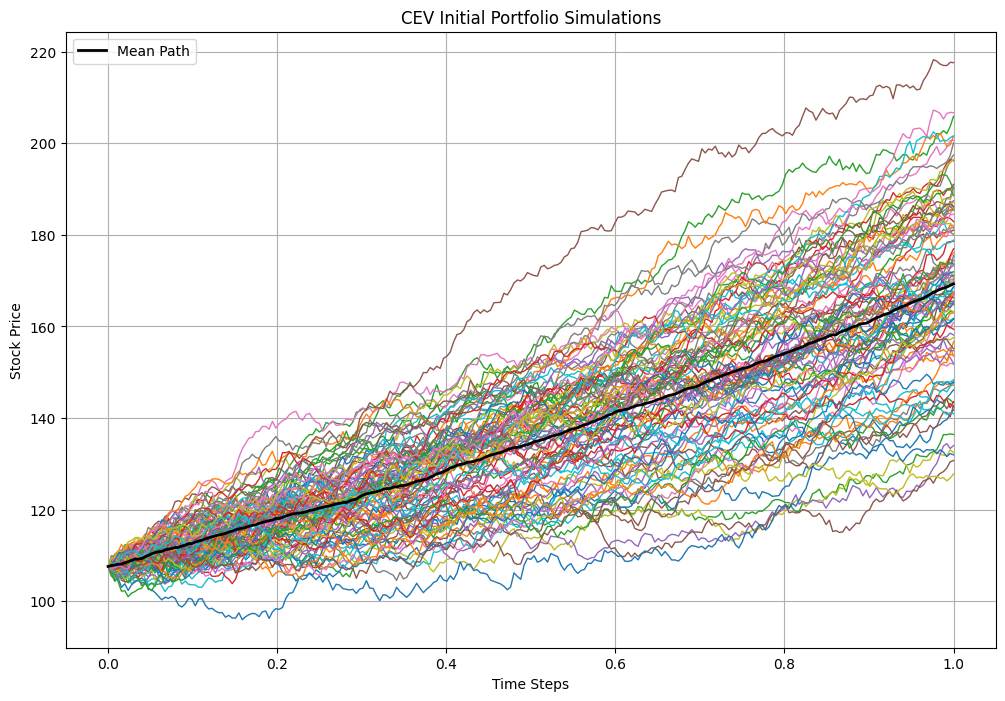

In [22]:
cev_init_port=dat_func.simulate_cev_portfolio(stock_df,init_weights)
vis.plot_paths(cev_init_port.iloc[:100],'CEV Initial Portfolio',True)

In [23]:
cev_ret=(cev_init_port.mean(axis=0).iloc[-1]-cev_init_port.mean(axis=0).iloc[0])/cev_init_port.mean(axis=0).iloc[0]
print(f'CEV Initial Portfolio Return: {round(cev_ret*100,2)}%')

CEV Initial Portfolio Return: 58.23%


### Heston Model:

Estimated JPM Heston Parameters: theta=0.07507922660370671, kappa=3.7049552190316963, sigma=0.6077771187320078, rho=-0.9998663253174258, v0=0.012313682496271218


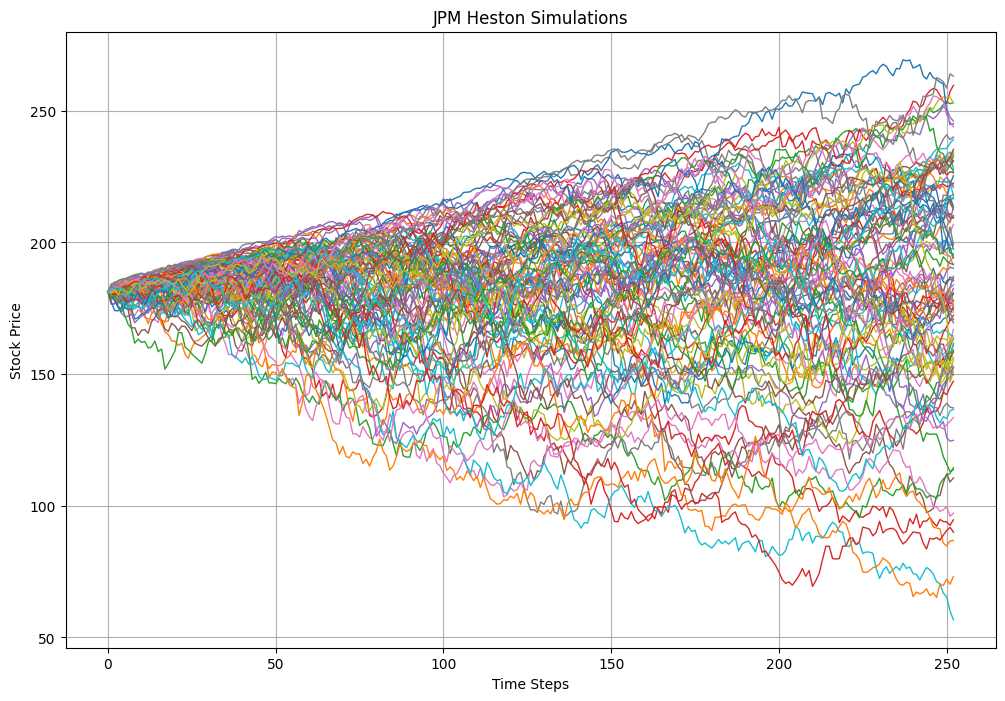

In [24]:
ex_heston_param=dat_func.estimate_heston_params(ex_stock,end_date,stock_df,risk_free_rate)
ex_heston_prices=dat_func.simulate_heston(ex_heston_param, stock_df[ex_stock][-1], risk_free_rate)
vis.plot_paths(ex_heston_prices[:100],f'{ex_stock} Heston')

Estimated CAT Heston Parameters: theta=0.12605046410106446, kappa=2.654400159596656, sigma=0.5832690881786545, rho=-0.9999989136227757, v0=0.01507959672504869
Estimated JNJ Heston Parameters: theta=4.452702086513111, kappa=1.6688775044273738, sigma=8.795813379820913, rho=-0.9997654290377096, v0=0.6387245894352801
Estimated JPM Heston Parameters: theta=0.07507950806736312, kappa=3.704931323153846, sigma=0.6077770567788268, rho=-0.9998664681614664, v0=0.012313681472240288
Estimated LIN Heston Parameters: theta=0.8743343752223227, kappa=13.405008132781512, sigma=0.28375417085995663, rho=-0.9999994919475312, v0=0.007903868415963794
Estimated MCD Heston Parameters: theta=0.13787770964053453, kappa=3.722452313374858, sigma=0.37222344277260744, rho=-0.9999716316406347, v0=0.014203047334545384
Estimated XLC Heston Parameters: theta=0.12271133538749085, kappa=6.958238541806867, sigma=0.6244590130527057, rho=-0.999999932198286, v0=0.01239047697425378
Estimated XLE Heston Parameters: theta=0.8249

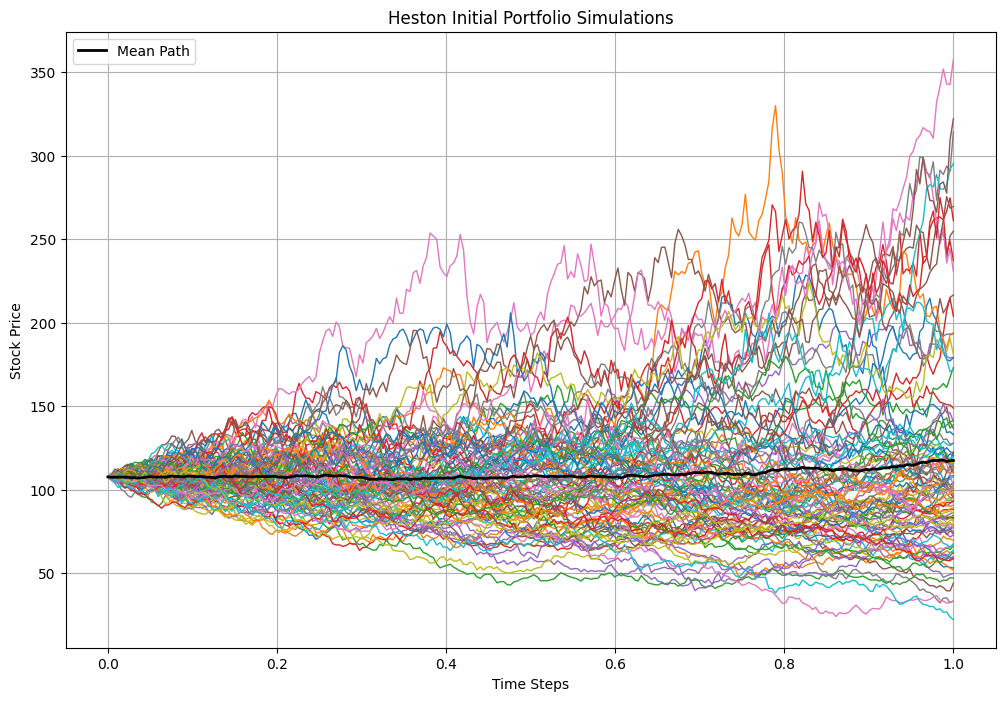

In [25]:
heston_init_port=dat_func.simulate_heston_portfolio(stock_df,init_weights,risk_free_rate)
vis.plot_paths(heston_init_port.iloc[:100],'Heston Initial Portfolio',True)

In [26]:
heston_ret=(heston_init_port.mean(axis=0).iloc[-1]-heston_init_port.mean(axis=0).iloc[0])/heston_init_port.mean(axis=0).iloc[0]
print(f'Heston Initial Portfolio Return: {round(heston_ret*100,2)}%')

Heston Initial Portfolio Return: 4.12%


## Simulation Portfolio:

In [33]:
sim_port_results=dat_func.calculate_simulate_portfolio(tickers,end_date,stock_df,returns_df,risk_free_rate,0.2,2500)
sim_port_weights={tick:sim_port_results.x[i] for i,tick in enumerate(tickers)}
sim_port_weights

Estimated XLC CEV Parameters: mu=0.0012330686837488214, std=0.7290676305378481, gamma=0.0
Estimated XLC Heston Parameters: theta=0.12271133539031721, kappa=6.958238541573077, sigma=0.6244590130542083, rho=-0.9999999321999555, v0=0.01239047697442629
Estimated MCD CEV Parameters: mu=-0.00019891143730459569, std=0.17518619559172285, gamma=0.4730267010742547
Estimated MCD Heston Parameters: theta=0.1152457447741933, kappa=3.8843995592964102, sigma=0.34731909646120007, rho=-0.9999988561461469, v0=0.01605607716966055
Estimated XLP CEV Parameters: mu=-1.9855543970422314e-05, std=0.4688248463733853, gamma=0.0
Estimated XLP Heston Parameters: theta=0.23650675884260056, kappa=6.360565537600475, sigma=0.660717125725165, rho=-0.999995325386431, v0=0.011261282118781217
Estimated XLE CEV Parameters: mu=0.000448423187477978, std=1.0066826972132676, gamma=0.0
Estimated XLE Heston Parameters: theta=0.8249342228120904, kappa=23.119231068844567, sigma=0.6010637460266772, rho=-0.9999966122504897, v0=0.014

{'XLC': -2.3119473713594858e-07,
 'MCD': -1.4491460361842234e-08,
 'XLP': 2.7393019029539725e-07,
 'XLE': 0.19999999999999923,
 'JPM': 0.2,
 'JNJ': -5.0762382716918864e-08,
 'CAT': 0.19999999999999615,
 'LIN': 0.19999999999999946,
 'XLRE': 0.19999999999999665,
 'XLK': -1.4354997967392436e-07,
 'XLU': -4.043269344073017e-08}

In [ ]:
with open('Data\\full_sim_port_weights.pkl', 'wb') as handle:
    pickle.dump(sim_port_weights, handle, protocol=pickle.HIGHEST_PROTOCOL)